In [1]:
%load_ext jupyternotify
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels as sm
import yfinance as yf

<IPython.core.display.Javascript object>

## Getting the Data ##

In [2]:
df = yf.download(['SPY', '^TNX', '^VIX'], 
                 interval='1mo', start='1990-01-01', end='2024-01-01')[['Adj Close']]['Adj Close']
df = df.dropna()
df['SPY'] = np.log(df['SPY']).diff()*100
df['^TNX'] = df['^TNX'].diff()*100
# df['^TNX'] = np.log(df['^TNX'])*100
df['^VIX'] = np.log(df['^VIX'])
df = df.dropna()
df

[*********************100%***********************]  3 of 3 completed


,SPY,^TNX,^VIX
Date,,,
1993-03-01,1.744066,0.000000,2.528126
1993-04-01,-2.120919,1.999998,2.519308
1993-05-01,2.661198,10.999966,2.600465
1993-06-01,-0.346154,-35.999966,2.421257
1993-07-01,0.219549,2.999973,2.462150
...,...,...,...
2023-01-01,6.557068,-34.999990,2.965273
2023-02-01,-2.546420,38.699985,3.030134
2023-03-01,3.259777,-42.199993,2.928524


## Choosing only 30 rows ##

In [3]:
# df = df.iloc[180:,:]

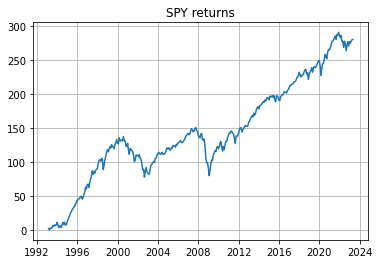

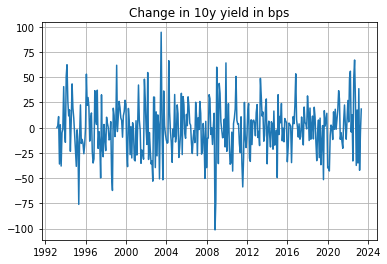

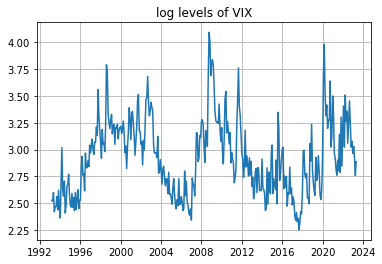

In [4]:
plt.plot(df['SPY'].cumsum())
plt.title('SPY returns')
plt.grid()
plt.show()

plt.plot(df['^TNX'])
plt.title('Change in 10y yield in bps')
plt.grid()
plt.show()

plt.plot(df['^VIX'])
plt.title('log levels of VIX')
plt.grid()
plt.show()

## Obtaining NW Estimates of the Mean ##

In [5]:
from statsmodels.nonparametric.kernel_regression import KernelReg
nw_reg1 = KernelReg(endog=df['SPY'], exog= df['^VIX'], var_type='c')
nw_reg2 = KernelReg(endog=df['^TNX'], exog= df['^VIX'], var_type='c')
spy_nw_mean = nw_reg1.fit()[0]
tnx_nw_mean = nw_reg2.fit()[0]
df['SPY Estimate'] = spy_nw_mean
df['^TNX Estimate'] = tnx_nw_mean

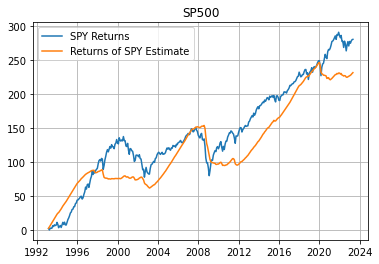

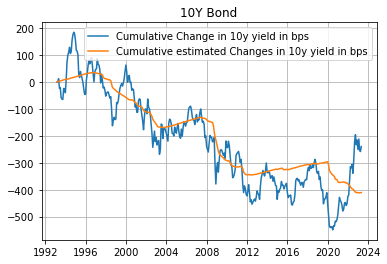

In [6]:
plt.plot(df['SPY'].cumsum(), label="SPY Returns")
plt.plot(df['SPY Estimate'].cumsum(), label='Returns of SPY Estimate')
plt.legend()
plt.grid()
plt.title("SP500")
plt.show()

plt.plot(df['^TNX'].cumsum(), label="Cumulative Change in 10y yield in bps")
plt.plot(df['^TNX Estimate'].cumsum(), label='Cumulative estimated Changes in 10y yield in bps')
plt.legend()
plt.grid()
plt.title("10Y Bond")
plt.show()

## NW Covariance Regression ##

In [7]:
def kernel_calc(U,u,h):
    kernel_val = (1/h)*(1/np.sqrt(2*np.pi))*np.exp(-0.5*(((U-u)/h)**2))
    return(kernel_val)

In [8]:
def fitted_val(u,h,dataset=df):
    denom = 0
    for i in dataset['^VIX']:
        denom += kernel_calc(i, u, h)
    num = np.zeros(4).reshape((2,2))
    for j in dataset.index:
        x_values = np.array(dataset.loc[j, ['SPY', '^TNX']]).reshape(2,1)
        x_mean_values = np.array(dataset.loc[j, ['SPY Estimate', '^TNX Estimate']]).reshape(2,1)
        demean_val = x_values - x_mean_values
        num_component = kernel_calc(dataset.loc[j, '^VIX'], u, h)*np.dot(demean_val, demean_val.T)
        num = num + kernel_calc(dataset.loc[j, '^VIX'], u, h)*np.dot(demean_val, demean_val.T)
        
    cov_matrix = num/denom
#     print(cov_matrix)
    return(cov_matrix)

## LOO Cross Validation ##

In [9]:
def cv_score(h):
    score = 0
    runs = 0
    for j in df.index:
        x_values = np.array(df.loc[j, ['SPY', '^TNX']]).reshape(2,1)
        x_mean_values = np.array(df.loc[j, ['SPY Estimate', '^TNX Estimate']]).reshape(2,1)
        demean_val = x_values - x_mean_values
        modified_df = df.drop(j)
        cov_matrix = fitted_val(df.loc[j, '^VIX'], h, dataset=modified_df)
        inv_matrix = np.linalg.inv(cov_matrix)
        log_term = np.log(np.linalg.det(cov_matrix))
        score += np.dot(np.dot(demean_val.T, inv_matrix), demean_val) + log_term
        runs += 1
        
    return(score/runs)

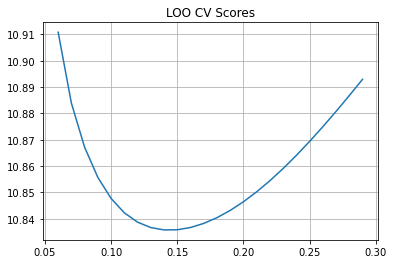

In [10]:
cv_scores = []
h_candidates = []
cv_scores_dct = {}
for h_candidate in range(6,30):
    h_candidates.append(h_candidate/100)
    loo_cv_score = cv_score(h_candidate/100)
    cv_scores.append(float(loo_cv_score))
    cv_scores_dct[float(loo_cv_score)] = h_candidate
#     print(h_candidate)
    
plt.plot(h_candidates, cv_scores)
plt.grid()
plt.title("LOO CV Scores")
plt.show()

In [11]:
optimal_h = cv_scores_dct[min(cv_scores)]/100
fitted_cov = []
fitted_var_spy = []
fitted_var_tnx = []
fitted_matrix = []
fitted_beta = []
for j in df.index:
    fitted_cov_matrix = fitted_val(df.loc[j, '^VIX'], optimal_h)
    fitted_matrix.append(fitted_cov_matrix)
    fitted_var_spy.append(fitted_cov_matrix[0,0])
    fitted_var_tnx.append(fitted_cov_matrix[1,1])
    fitted_cov.append(fitted_cov_matrix[0,1])
    fitted_beta.append(fitted_cov_matrix[0,1] - (fitted_cov_matrix[1,1]/10000))
fitted_corr = np.array(fitted_cov)/np.sqrt(np.array(fitted_var_spy)*np.array(fitted_var_tnx))

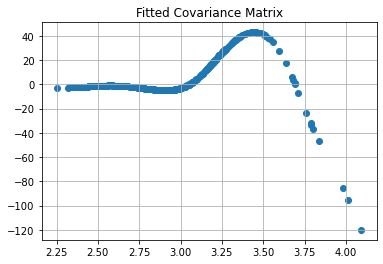

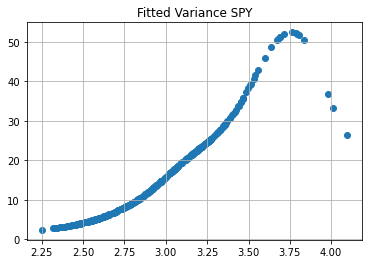

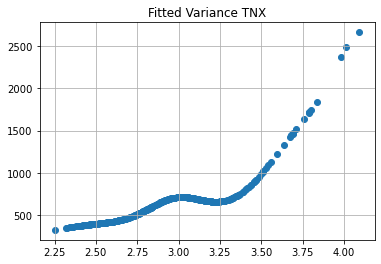

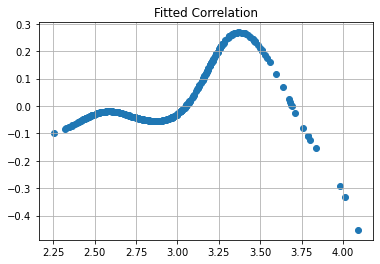

In [12]:
plt.scatter(df['^VIX'], fitted_cov)
plt.grid()
plt.title("Fitted Covariance Matrix")
plt.show()

plt.scatter(df['^VIX'], fitted_var_spy)
plt.grid()
plt.title("Fitted Variance SPY")
plt.show()

plt.scatter(df['^VIX'], fitted_var_tnx)
plt.grid()
plt.title("Fitted Variance TNX")
plt.show()

plt.scatter(df['^VIX'], fitted_corr)
plt.grid()
plt.title('Fitted Correlation')
plt.show()

## Confidence Intervals via Bootstrapping ##

In [13]:
bootstraps = []
for boot in range(200):
    bootstraps.append(df.sample(len(df), replace=True).reset_index())
    
cov_dct = {}
spy_var_dct = {}
tnx_var_dct = {}
corr_dct = {}
beta_cov_dct = {}
for ivol in df['^VIX']:
    cov_dct[ivol] = []
    spy_var_dct[ivol] = []
    tnx_var_dct[ivol] = []
    corr_dct[ivol] = []
    beta_cov_dct[ivol] = []

i = 0
for bootstrap_df in bootstraps:
    i = i+1
    for ivol in df['^VIX']:
        boot_cov_matrix = fitted_val(ivol, optimal_h, dataset=bootstrap_df)
        cov_dct[ivol].append(boot_cov_matrix[0,1])
        spy_var_dct[ivol].append(boot_cov_matrix[0,0])
        tnx_var_dct[ivol].append(boot_cov_matrix[1,1])
        corr_dct[ivol].append(boot_cov_matrix[0,1]/(np.sqrt(boot_cov_matrix[0,0]*boot_cov_matrix[1,1])))
        beta_cov_dct[ivol].append(boot_cov_matrix[0,1] - (boot_cov_matrix[1,1]/10000))

In [14]:
ci = 0.05
upper_lim_cov = []
lower_lim_cov = []
upper_lim_spyvar = []
lower_lim_spyvar = []
upper_lim_tnxvar = []
lower_lim_tnxvar = []
upper_lim_corr = []
lower_lim_corr = []
upper_lim_beta = []
lower_lim_beta = []

upper_lim2_cov = []
lower_lim2_cov = []
upper_lim2_spyvar = []
lower_lim2_spyvar = []
upper_lim2_tnxvar = []
lower_lim2_tnxvar = []
upper_lim2_corr = []
lower_lim2_corr = []

for ivol in df['^VIX']:
    upper_lim_cov.append(np.quantile(np.array(cov_dct[ivol]), 1 - ci))
    lower_lim_cov.append(np.quantile(np.array(cov_dct[ivol]), ci))
    upper_lim_spyvar.append(np.quantile(np.array(spy_var_dct[ivol]), 1 - ci))
    lower_lim_spyvar.append(np.quantile(np.array(spy_var_dct[ivol]), ci))
    upper_lim_tnxvar.append(np.quantile(np.array(tnx_var_dct[ivol]), 1 - ci))
    lower_lim_tnxvar.append(np.quantile(np.array(tnx_var_dct[ivol]), ci))
    upper_lim_corr.append(np.quantile(np.array(corr_dct[ivol]), 1 - ci))
    lower_lim_corr.append(np.quantile(np.array(corr_dct[ivol]), ci))
    upper_lim_beta.append(np.quantile(np.array(beta_cov_dct[ivol]), 1 - ci))
    lower_lim_beta.append(np.quantile(np.array(beta_cov_dct[ivol]), ci))
    
    upper_lim2_cov.append(np.quantile(np.array(cov_dct[ivol]), 0.90))
    lower_lim2_cov.append(np.quantile(np.array(cov_dct[ivol]), 0.10))
    upper_lim2_spyvar.append(np.quantile(np.array(spy_var_dct[ivol]), 0.90))
    lower_lim2_spyvar.append(np.quantile(np.array(spy_var_dct[ivol]), 0.10))
    upper_lim2_tnxvar.append(np.quantile(np.array(tnx_var_dct[ivol]), 0.90))
    lower_lim2_tnxvar.append(np.quantile(np.array(tnx_var_dct[ivol]), 0.10))
    upper_lim2_corr.append(np.quantile(np.array(corr_dct[ivol]), 0.90))
    lower_lim2_corr.append(np.quantile(np.array(corr_dct[ivol]), 0.10))

In [15]:
results_df = pd.DataFrame([list(df['^VIX']), fitted_cov, fitted_var_spy, fitted_var_tnx, fitted_corr,
                           upper_lim_cov, lower_lim_cov, upper_lim_spyvar, lower_lim_spyvar, 
                           upper_lim_tnxvar, lower_lim_tnxvar, upper_lim_corr, lower_lim_corr,
                           upper_lim_beta, lower_lim_beta, fitted_beta,
                           upper_lim2_cov, lower_lim2_cov, upper_lim2_spyvar, lower_lim2_spyvar, 
                           upper_lim2_tnxvar, lower_lim2_tnxvar, upper_lim2_corr, lower_lim2_corr]).T
results_df.columns = ['log VIX', 'Fitted Cov', 'Fitted SPY Var', 'Fitted TNX Var', 'Fitted Corr',
                      'Up Cov', 'Low Cov', 'Up SPY Var', 'Low SPY Var', 'Up TNX Var', 'Low TNX Var',
                      'Up Corr', 'Low Corr', 'Up Beta', 'Low Beta', 'Fitted Beta', 
                      'Up Cov2', 'Low Cov2', 'Up SPY Var2', 'Low SPY Var2', 
                      'Up TNX Var2', 'Low TNX Var2','Up Corr2', 'Low Corr2']
results_df['VIX'] = np.exp(results_df['log VIX'])
results_df = results_df.sort_values(by='VIX')

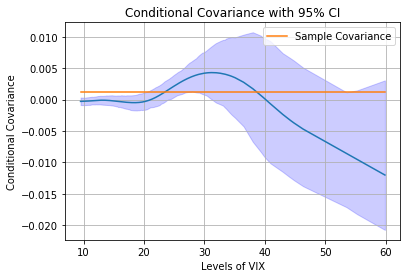

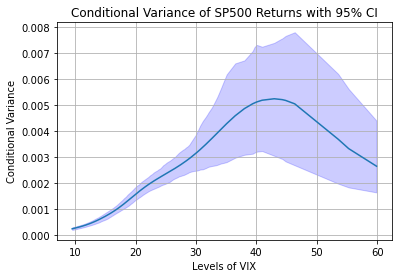

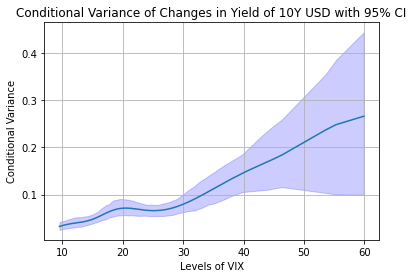

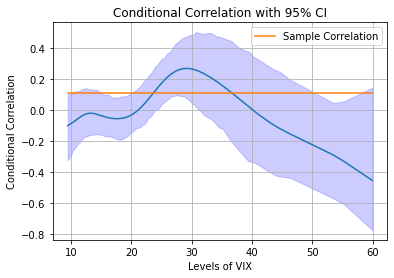

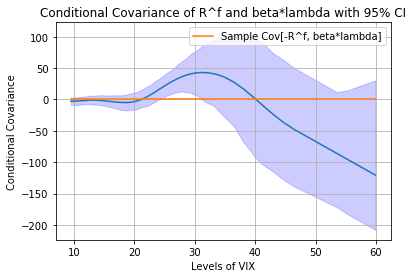

In [16]:
scale_factor = 10**4
avg_cov = np.cov(df['SPY'], df['^TNX'])[0,1]
avg_corr = np.corrcoef(df['SPY'], df['^TNX'])[0,1]
plt.plot(results_df['VIX'], results_df['Fitted Cov']/scale_factor)
plt.fill_between(results_df['VIX'], results_df['Low Cov']/scale_factor, results_df['Up Cov']/scale_factor, 
                 color='blue', alpha=0.2)
plt.plot([results_df['VIX'].min(), results_df['VIX'].max()], [avg_cov/scale_factor, avg_cov/scale_factor], 
         label='Sample Covariance')
plt.legend()
# plt.fill_between(results_df['VIX'], results_df['Low Cov2']/scale_factor, results_df['Up Cov2']/scale_factor, 
#                  color='blue', alpha=0.2)
plt.grid()
plt.title("Conditional Covariance with 95% CI")
plt.xlabel("Levels of VIX")
plt.ylabel("Conditional Covariance")
plt.show()

plt.plot(results_df['VIX'], results_df['Fitted SPY Var']/scale_factor)
plt.fill_between(results_df['VIX'], results_df['Low SPY Var']/scale_factor, results_df['Up SPY Var']/scale_factor, 
                 color='blue', alpha=0.2)
# plt.fill_between(results_df['VIX'], results_df['Low SPY Var2']/scale_factor, results_df['Up SPY Var2']/scale_factor, 
#                  color='blue', alpha=0.2)
plt.grid()
plt.title("Conditional Variance of SP500 Returns with 95% CI")
plt.xlabel("Levels of VIX")
plt.ylabel("Conditional Variance")
plt.show()

plt.plot(results_df['VIX'], results_df['Fitted TNX Var']/scale_factor)
plt.fill_between(results_df['VIX'], results_df['Low TNX Var']/scale_factor, results_df['Up TNX Var']/scale_factor, 
                 color='blue', alpha=0.2)
# plt.fill_between(results_df['VIX'], results_df['Low TNX Var2']/scale_factor, results_df['Up TNX Var2']/scale_factor, 
#                  color='blue', alpha=0.2)
plt.grid()
plt.title("Conditional Variance of Changes in Yield of 10Y USD with 95% CI")
plt.xlabel("Levels of VIX")
plt.ylabel("Conditional Variance")
plt.show()

plt.plot(results_df['VIX'], results_df['Fitted Corr'])
plt.fill_between(results_df['VIX'], results_df['Low Corr'], results_df['Up Corr'], 
                 color='blue', alpha=0.2)
plt.plot([results_df['VIX'].min(), results_df['VIX'].max()], [avg_corr, avg_corr], 
         label='Sample Correlation')
plt.legend()
# plt.fill_between(results_df['VIX'], results_df['Low Corr2'], results_df['Up Corr2'], 
#                  color='blue', alpha=0.2)
plt.grid()
plt.title("Conditional Correlation with 95% CI")
plt.xlabel("Levels of VIX")
plt.ylabel("Conditional Correlation")
plt.show()

plt.plot(results_df['VIX'], results_df['Fitted Beta'])
plt.fill_between(results_df['VIX'], results_df['Low Beta'], results_df['Up Beta'], 
                 color='blue', alpha=0.2)
plt.plot([results_df['VIX'].min(), results_df['VIX'].max()], [avg_corr, avg_corr], 
         label='Sample Cov[-R^f, beta*lambda]')
plt.legend()
# plt.fill_between(results_df['VIX'], results_df['Low Corr2'], results_df['Up Corr2'], 
#                  color='blue', alpha=0.2)
plt.grid()
plt.title("Conditional Covariance of R^f and beta*lambda with 95% CI")
plt.xlabel("Levels of VIX")
plt.ylabel("Conditional Covariance")
plt.show()